In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score 
from sklearn.metrics import precision_recall_fscore_support, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import functools

import h5py

In [2]:
P_THRESHOLD=0.5

### Which data

In [3]:
DATADIR = os.getenv('DATADIR')

In [4]:
print("model v2.0.0 was run on data dated {}".format(DATADIR))

model v2.0.0 was run on data dated /data/2018-03-27


### Read in hard-to-tag content items

In [5]:
hard_to_tag = pd.read_csv(
    os.path.join(DATADIR, 'hard_to_tag_ukeconomy.csv.gz'),
    dtype=object,
    compression='gzip'
)

In [6]:
hard_to_tag.shape

(4744224, 19)

In [7]:
hard_to_tag.columns

Index(['content_id', 'base_path_x', 'prob', 'taxon2label', 'base_path_y',
       'description', 'document_type', 'document_type_gp',
       'first_published_at', 'level1taxon', 'locale',
       'primary_publishing_organisation', 'publishing_app', 'taxon_id',
       'title', 'untagged_type', 'updated_at', 'prob_cat', '_merge'],
      dtype='object')

In [8]:
hard_to_tag.content_id.nunique()

20996

In [ ]:
#hard_to_tag.sort_values('support', ascending=False).plot(x='level2label', y='support', kind = 'bar', figsize=(35,10), legend=False)

In [ ]:
hard_to_tag['prob'].hist(by=hard_to_tag['untagged_type'], range=(0, 1), figsize=(20, 10), bins=500)

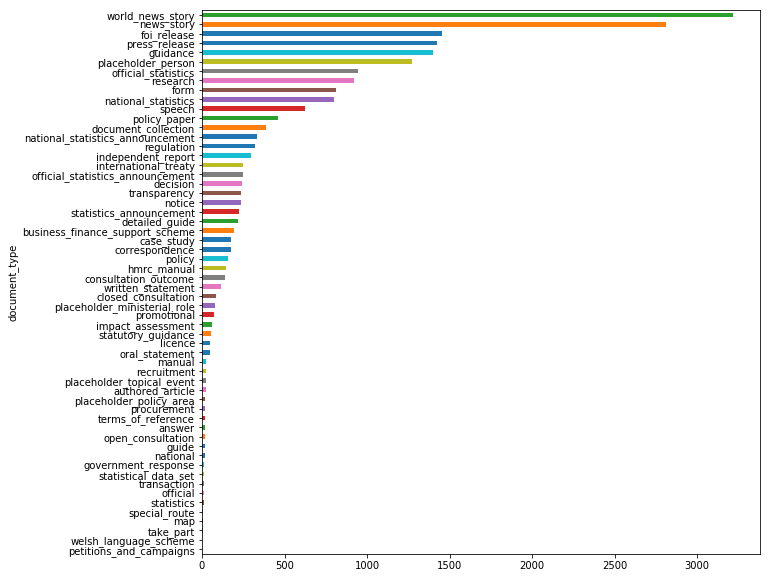

In [33]:
hard_to_tag_dedup = hard_to_tag.drop_duplicates('content_id')

hard_to_tag_dedup.groupby('document_type').size().sort_values(ascending=True).plot(kind = 'barh', figsize=(10, 10))

In [79]:


hard_to_tag_dedup.groupby('document_type').size()

document_type
answer                                18
authored_article                      23
business_finance_support_scheme      193
case_study                           178
closed_consultation                   86
consultation_outcome                 137
correspondence                       176
decision                             244
detailed_guide                       219
document_collection                  386
foi_release                         1456
form                                 814
government_response                   14
guidance                            1402
guide                                 17
hmrc_manual                          145
impact_assessment                     61
independent_report                   299
international_treaty                 251
licence                               47
manual                                27
map                                    5
national                              16
national_statistics                  799
na

In [ ]:
# atleast1pct = hard_to_tag[hard_to_tag['prob']>=0.01]
# atleast1pct.shape

In [ ]:
# atleast1pct['prob'].hist(range=(0, 1), figsize=(30, 10), bins=500)

In [ ]:
# atleast1pct['prob'].hist(by=atleast1pct['untagged_type'], range=(0, 1), figsize=(20, 10), bins=500)

In [ ]:
# #TODO: work out how to standardise ylim to 0, 3000 
# atleast1pct['prob'].hist(by=atleast1pct['taxon2label'], range=(0, 1), figsize=(50, 50), bins=50)

In [ ]:
hard_to_tag.groupby(['content_id']).size().sort_values(ascending=True).describe()

In [ ]:
hard_to_tag['prob'].hist(by=hard_to_tag['taxon2label'], figsize=(50, 50), bins=50)

In [ ]:
hard_to_tag[['base_path', 'taxon2label', 'title', 'description']][100:150]


In [ ]:
taxons = predictions['taxon2label'].unique()
subsample = pd.DataFrame(columns = predictions.columns)

for taxon in taxons:
    taxon_spec = predictions.loc[predictions['taxon2label']==taxon]
    sample_size = int(round(taxon_spec.shape[0]*0.1))
    if not sample_size == 0 and taxon_spec.shape[0] > sample_size:
        print(taxon,": SAMPLING AT:",sample_size)
        subsample = subsample.append(taxon_spec.sample(n=sample_size), ignore_index=True)

In [ ]:
subsample[['base_path', 'taxon2label', 'title', 'description']].to_csv(os.path.join(DATADIR, 'new_predictions_subsample.csv.gz'),compression='gzip',index=False)

### recency

In [9]:
hard_to_tag['first_published_at'] = pd.to_datetime(hard_to_tag['first_published_at'])
hard_to_tag.index = hard_to_tag['first_published_at']

In [10]:
hard_to_tag.sort_values(['prob', 'content_id'], ascending=False)

,content_id,base_path_x,prob,taxon2label,base_path_y,description,document_type,document_type_gp,first_published_at,level1taxon,locale,primary_publishing_organisation,publishing_app,taxon_id,title,untagged_type,updated_at,prob_cat,_merge
first_published_at,,,,,,,,,,,,,,,,,,,
2005-12-09 00:00:00,5df23575-7631-11e4-a3cb-005056011aef,NaN,9.999995536412404e-17,Armed forces support for activities in the UK,/government/publications/police-stations-revie...,foi 2565 we received a request under the freed...,foi_release,transparency,2005-12-09 00:00:00,NaN,en,Home Office,whitehall,NaN,police stations reviewed by home office design...,untagged,2018-01-10 12:32:38.368,<0.01,right_only
2015-11-24 16:09:00,1b703d8d-ba94-4661-83c9-39b3c042baf8,NaN,9.999993055842538e-10,Safeguarding and social care for children,/government/news/uk-sets-the-agenda-at-un-anti...,the 6th conference of states parties (cosp) to...,world_news_story,news_and_announcements,2015-11-24 16:09:00,NaN,en,NaN,whitehall,NaN,uk sets the agenda at un anti-corruption confe...,untagged,2018-03-13 15:09:14.214,<0.01,right_only
2017-02-27 15:14:53,00790578-bdcf-456d-b3f8-af03f974cc6e,NaN,9.999988833442329e-06,"Knife, gun and gang crime",/government/publications/response-to-an-foi-as...,the response to an foi asking for details of v...,foi_release,transparency,2017-02-27 15:14:53,NaN,en,Civil Nuclear Police Authority,whitehall,NaN,response to an foi asking for details of cncs ...,untagged,2017-06-01 19:07:01.118,<0.01,right_only
2013-07-09 11:11:00,5e39179e-7631-11e4-a3cb-005056011aef,NaN,9.99998235329258e-08,Permanent stay in the UK,/government/news/prime-ministers-video-message...,the prime minister has sent his best wishes to...,news_story,news_and_announcements,2013-07-09 11:11:00,NaN,en,"Prime Minister's Office, 10 Downing Street",whitehall,NaN,prime minister's video message for ramadan 2013,untagged,2017-10-10 12:01:06.605,<0.01,right_only
2012-01-23 00:00:00,5c7829ee-7631-11e4-a3cb-005056011aef,NaN,9.99998235329258e-08,Careers in transport,/government/news/juror-convicted-for-internet-...,juror jailed for researching the case she was ...,news_story,news_and_announcements,2012-01-23 00:00:00,NaN,en,Attorney General's Office,whitehall,NaN,juror convicted for internet research,untagged,2018-01-10 13:11:32.308,<0.01,right_only
2011-02-22 00:00:00,5e0d1557-7631-11e4-a3cb-005056011aef,NaN,9.999963168638717e-08,Child maintenance reform,/government/news/earthquake-in-new-zealand,"prime minister david cameron has sent his ""dee...",news_story,news_and_announcements,2011-02-22 00:00:00,NaN,en,"Prime Minister's Office, 10 Downing Street",whitehall,NaN,earthquake in new zealand,untagged,2017-10-10 11:59:44.228,<0.01,right_only
2015-04-01 15:37:00,abc2001a-dacf-4fc9-a211-5fb24e88f64e,NaN,9.999961912399158e-05,Tourism,/government/news/scouts-del-ecuador-cumplen-95...,the ambassador patrick mullee was presented wi...,world_news_story,news_and_announcements,2015-04-01 15:37:00,NaN,en,NaN,whitehall,NaN,scouts of ecuador celebrates its 95th anniversary,untagged,2017-09-22 18:35:57.912,<0.01,right_only
2016-07-03 12:55:00,01d53c28-c5a4-417c-88db-2a69585e733f,NaN,9.999959083017984e-09,Boating and inland waterways,/government/news/statement-from-british-high-c...,message from high commissioner alison blake ac...,world_news_story,news_and_announcements,2016-07-03 12:55:00,NaN,en,NaN,whitehall,NaN,statement from british high commission on dhak...,untagged,2018-03-13 15:12:22.429,<0.01,right_only
2015-12-23 12:41:00,faf1fdf9-9487-40a8-b683-7a97b678193d,NaN,9.999953068298012e-14,Universal Credit,/government/publications/foi-responses-publish...,ministry of defence (mod) freedom of informati...,foi_release,transparency,2015-12-23 12:41:00,Defence,en,Ministry of Defence,whitehall,e491505c-77ae-45b2-84be-8c94b94f6a2b,foi responses published by mod: week commencin...,level1only,2018-03-13 15:22:59.572,<0.01,right_only


(0, 5000)

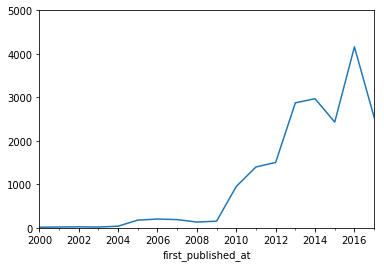

In [12]:

hard_to_tagged = hard_to_tag_dedup['first_published_at'].resample('Y').count().plot()
hard_to_tagged.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2017-12-31'))
hard_to_tagged.set_ylim([0, 5000])

In [ ]:
# cols =np.arange(1, 29)
# cols

In [ ]:
#hardtotag_guidance = hard_to_tag[hard_to_tag['document_type']=='guidance'].drop(hard_to_tag.columns[cols], axis=1 ).sort_values('prob')

(0, 300)

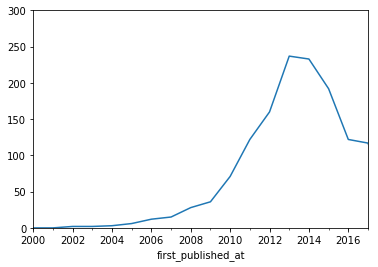

In [56]:
guidance = hard_to_tag_dedup[hard_to_tag_dedup['document_type']=='guidance']

hard_to_tagged = guidance['first_published_at'].resample('Y').count().plot()
hard_to_tagged.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2017-12-31'))
hard_to_tagged.set_ylim([0, 300])

In [76]:
primpub_grouped = guidance.groupby(['primary_publishing_organisation', pd.Grouper(freq='Y')])['first_published_at'].count()
guidance_by_year = primpub_grouped.unstack('primary_publishing_organisation', fill_value=0)

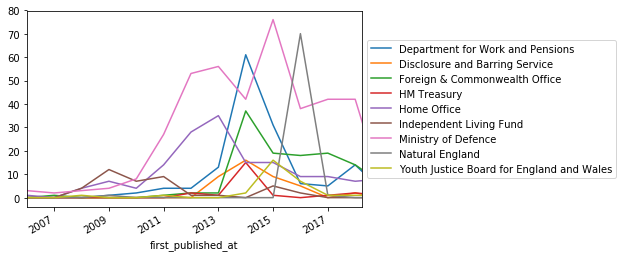

In [77]:
top_count = guidance_by_year.loc[:,guidance_by_year.max() > 10]
ax = top_count.plot()
ax.set_xlim(pd.Timestamp('2005-12-31'), pd.Timestamp('2018-03-27'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

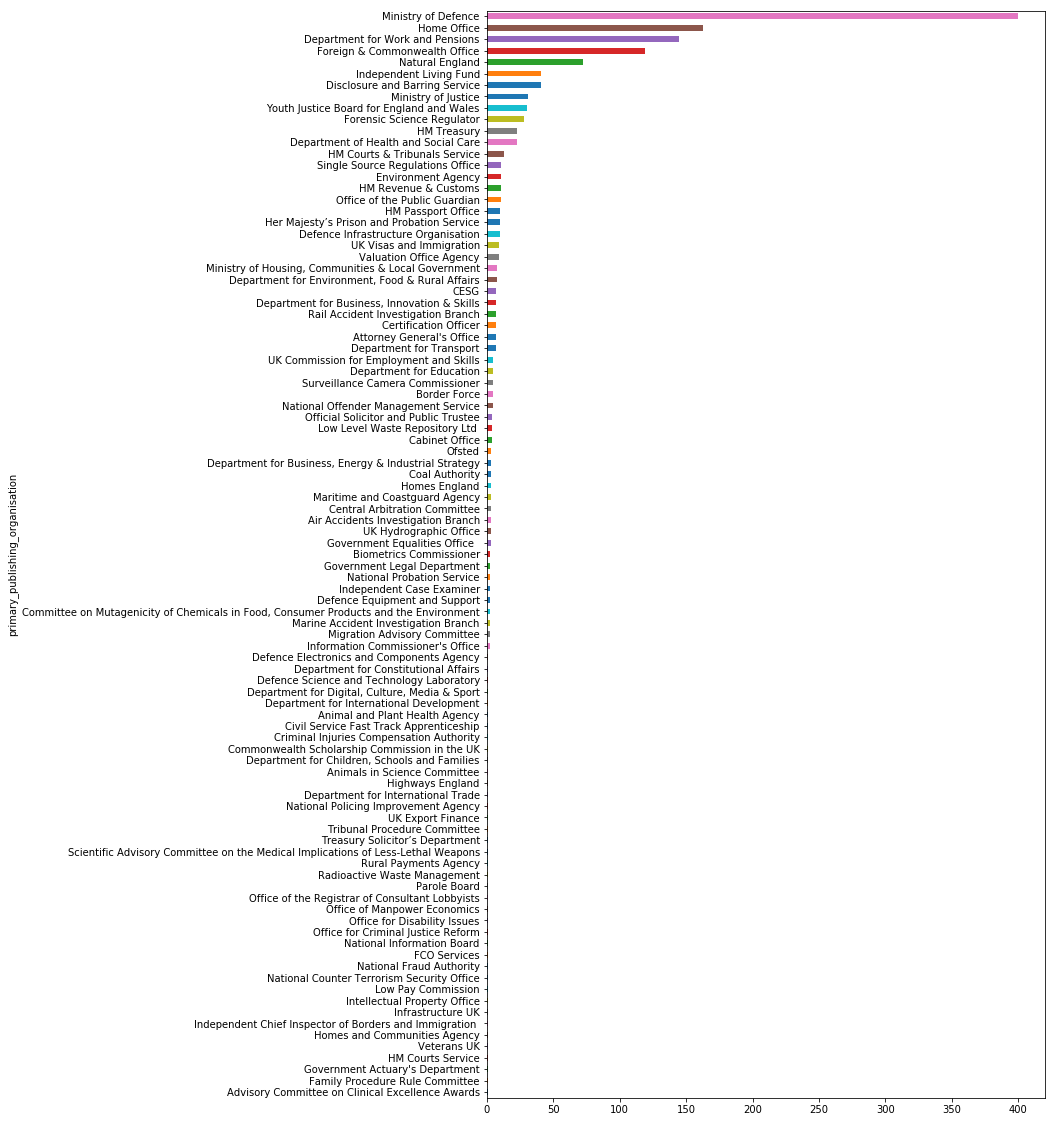

In [40]:
hard_to_tag_dedup[hard_to_tag_dedup['document_type']=='guidance'].groupby('primary_publishing_organisation').size().sort_values(ascending=True).plot(kind = 'barh', figsize=(10, 20))

1400


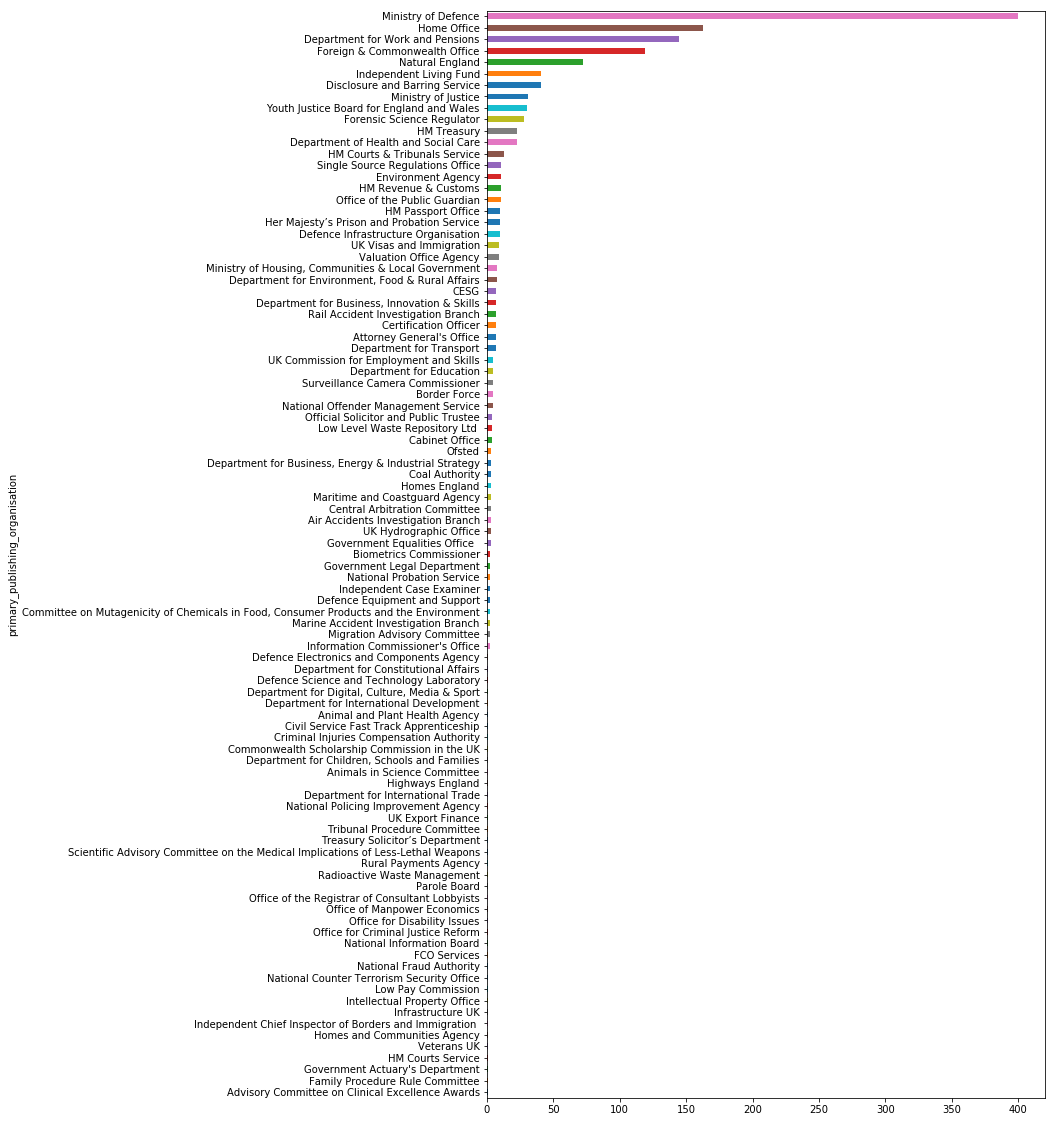

In [48]:
prim_pub = hard_to_tag_dedup[hard_to_tag_dedup['document_type']=='guidance'].groupby('primary_publishing_organisation').size()
print(prim_pub.sum())
prim_pub[prim_pub>0].sort_values(ascending=True).plot(kind = 'barh', figsize=(10, 20))

In [ ]:
fig = plt.figure(figsize=(15, 7))
ax = hardtotag_guidance['first_published_at_y'].resample('Y').count().plot()
ax.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2018-03-12'))


In [ ]:
fig = plt.figure(figsize=(15, 7))
ay = tagged_guidance['first_published_at'].resample('Y').count().plot()
ay.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2018-03-12'))

In [ ]:
hardtotag_guidance[['content_id', 'title_y', 'description_y', 'body_y', 'prob_y', 'taxon2label_y' ]].to_csv(os.path.join(DATADIR, 'hardtotag_guidance.csv.gz'), compression='gzip')

In [ ]:
not_predicted = no_predictions_dedup['first_published_at_y'].resample('Y').count().plot()
not_predicted.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2017-12-31'))

In [ ]:

fig = plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.title('predictions at 50% threshold')
predicted = predictions_dedup['first_published_at'].resample('Y').count().plot()
predicted.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2018-03-12'))
predicted.set_ylim([0, 10000])
predicted.axes.get_xaxis().set_ticklabels([])
predicted.set_xlabel('')

plt.subplot(2, 1, 2)
not_predicted = no_predictions_dedup['first_published_at_y'].resample('Y').count().plot()
not_predicted.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2018-03-12'))
plt.title('No predictions above 50%')
plt.ylabel('Count')
not_predicted.set_ylim([0, 10000])






fig.tight_layout()

In [69]:

doctype_grouped = hard_to_tag_dedup.groupby(['document_type', pd.Grouper(freq='Y')])['first_published_at'].count()
count_by_year = doctype_grouped.unstack('document_type', fill_value=0)

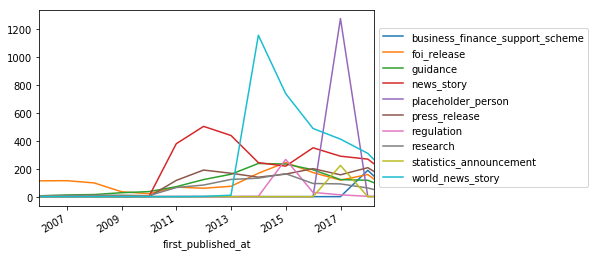

In [75]:
top_count = count_by_year.loc[:,count_by_year.max() > 160]
ax = top_count.plot()
ax.set_xlim(pd.Timestamp('2005-12-31'), pd.Timestamp('2018-03-27'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [30]:
lab = count_by_year.stack().reset_index()
lab.columns = ['date', 'document_type', 'percent']
bydoctype_year = lab.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
bydoctype_pcts = bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

bydoctype_pcts.columns = bydoctype_pcts.columns.droplevel(0)

top_pct = bydoctype_pcts[['guidance', 
                          'placeholder_person', 
                          'research', 
                          'world_news_story', 
                          'news_story', 
                          'foi_release',
                          'national_statistics',
                          'official_statistics', 
                          'press_release'
 ]]

(0, 100)

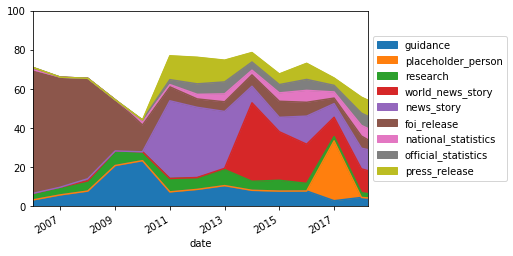

In [71]:
ut = top_pct.plot(kind='area', stacked=True)
ut.set_xlim(pd.Timestamp('2005-12-31'), pd.Timestamp('2018-03-27'))
ut.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ut.set_ylim(0, 100)

In [ ]:
doctype_grouped = no_predictions_dedup.groupby(['document_type_y', pd.Grouper(freq='Y')])['first_published_at_y'].count()
count_by_year = doctype_grouped.unstack('document_type_y', fill_value=0)

top_count = count_by_year.loc[:,count_by_year.max() > 300]
ax = top_count.plot()
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2018-03-12'))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
ax = predictions_dedup['first_published_at'].resample('Y').count().plot()
ax.set_xlim(pd.Timestamp('2000-12-31'), pd.Timestamp('2018-03-12'))

In [ ]:
lab = count_by_year.stack().reset_index()
lab.columns = ['date', 'document_type', 'percent']
bydoctype_year = lab.groupby(['date', 'document_type']).agg({'percent': 'sum'})
# Change: groupby state_office and divide by sum
bydoctype_pcts = bydoctype_year.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).unstack('document_type', fill_value=0)

bydoctype_pcts.columns = bydoctype_pcts.columns.droplevel(0)

top_pct = bydoctype_pcts[['organisation', 
                          'person', 
                          'placeholder_person', 
                          'regulation', 
                          'world_news_story', 
                          'news_story', 
                          'foi_release',
                          'guidance',
                          'national_statistics',
                          'official_statistics', 
                          'press_release',
                          'transparency'
 ]]



In [ ]:
ut = top_pct.plot(kind='area', stacked=True)
ut.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2018-03-12'))
ut.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [81]:
hard_to_tag_dedup.columns

Index(['content_id', 'base_path_x', 'prob', 'taxon2label', 'base_path_y',
       'description', 'document_type', 'document_type_gp',
       'first_published_at', 'level1taxon', 'locale',
       'primary_publishing_organisation', 'publishing_app', 'taxon_id',
       'title', 'untagged_type', 'updated_at', 'prob_cat', '_merge'],
      dtype='object')

In [87]:
hard_to_tag_dedup[['content_id', 'base_path_y', 'title', 'description', 'document_type']].to_csv(os.path.join(DATADIR, "hard_to_tag_clean.csv.gz"), compression='gzip',index=False)